In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns

import time
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import optuna

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#To show all rows in output
pd.set_option('display.max_rows', None)

# Step 1. 

## 1.1. Reading Data:

In [5]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [6]:
labels = pd.read_csv('labels.csv')
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [7]:
labels.shape[0]

801

In [8]:
df.shape[0]

801

## 1.2. Merge data with labels:

In [9]:
df_labels = pd.merge(labels, df, on='Unnamed: 0')

In [10]:
df_labels.shape[0]

801

In [11]:
df_labels.head()

,Unnamed: 0,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [12]:
# Check is there are any missing values:
df_labels[df_labels.isnull().any(axis=1)]

#No Missisng values

,Unnamed: 0,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530


- No missing data in the database

## 1.3. Hierarchically-clustered heatmap:

Note: This type of graph can be obtained for numerical dataset only.
      
      So, the Hierarchically-clustered heatmap will be plotted for numerical features only.

In [10]:
# Looking for numerical columns only:
heatmap = df_labels.drop(columns="Unnamed: 0").set_index("Class")

heatmap.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
Class,,,,,,,,,,,,,,,,,,,,,
PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [ ]:
# Perform hierarchical clustering on the dataset
clustered_data = sns.clustermap(heatmap)



## 1.4. Null-Hypothesis Testing

**Null hypothesis:** There is no significant difference in the gene expression values among the different types of tumors (BRCA, KIRC, COAD, LUAD, and PRAD).

### 1.4.1. Normal Distribution Tests (Anderson-Darling Test):

**Before to test the hypothesis, I want to know which feature (genes) have nolmal dictributions and which have not.

 - To do this I apply Anderson-Darling Test. This test can be used to assess the normality of a distribution. 
 - It provides a critical value and computes a statistic based on the data. If the computed statistic is less than the critical value, it indicates that the data follows a normal distribution.

In [13]:
# Anderson-Darling Test

from scipy.stats import anderson

gene_columns = df_labels.select_dtypes(include=['float64', 'int64']).columns

normal_columns = []
non_normal_columns = []

for column in gene_columns:
    result = anderson(df_labels[column])
    critical_values = result.critical_values
    statistic = result.statistic
    
    # Compare the computed statistic with critical values
    if all(statistic < value for value in critical_values):
        normal_columns.append(column)
    else:
        non_normal_columns.append(column)

print("Normally Distributed Columns:", len(normal_columns))
print("Non-Normally Distributed Columns:", len(non_normal_columns))

Normally Distributed Columns: 1591
Non-Normally Distributed Columns: 18940


- According to the Anderson-Darling Test only 1591 genes are distributed normaly (7.75%).

- The rest of the genes (18940 genes or 92.25%) are NOT distributed normaly.

**Conclutions:** In this caase (when most part of dataset are not normally distributed), I will use non-parametric tests to test the null hypothesis. Non-parametric tests do not assume any specific distribution for the data and are suitable for analyzing data that does not meet the assumptions of normality.

Selected Statistical Test to check hypothesis:
- Kruskal-Wallis test. This test is used to compare more than two independent groups to determine if there are any significant differences between them. It is a non-parametric alternative to one-way ANOVA and is used to compare the distributions of multiple groups. It does not assume a specific distribution of the data.

### 1.4.2. Kruskal-Wallis test

- The Kruskal-Wallis test requires variability in the data to perform the analysis. If all the values for a gene column are identical, the test cannot be applied. 

- In the first step I need to check what gene columns have identical values only (constants).

In [14]:
# Create an empty list to store gene columns with identical values
identical_genes = []

# Iterate over the gene columns
for gene_column in gene_columns:
    # Get the unique values in the gene column
    unique_values = df_labels[gene_column].unique()
    
    # Check if all values in the gene column are identical
    if len(unique_values) == 1:
        identical_genes.append(gene_column)

# Print the list of gene columns with identical values
print("Gene Columns with Identical Values:")
print(len(identical_genes))

Gene Columns with Identical Values:
267


- I found 267 constant features.
- Name of these columns can be found in the 'identical_genes' list.
- These genes are not significant. I will drop them.

In [15]:
# I will drop them.

df_no_const = df_labels.drop(columns=identical_genes)

In [16]:
# Original Number of genes:
df_labels.shape[1]

20533

In [17]:
# Number of genes without constants:
df_no_const.shape[1]

20266

In [18]:
#Kruskal-Wallis test:

from scipy.stats import kruskal

# Filter the samples based on tumor types
brca = df_no_const[df_no_const['Class'] == 'BRCA']
kirc = df_no_const[df_no_const['Class'] == 'KIRC']
coad = df_no_const[df_no_const['Class'] == 'COAD']
luad = df_no_const[df_no_const['Class'] == 'LUAD']
prad = df_no_const[df_no_const['Class'] == 'PRAD']

# Create a list of gene columns
gene_columns = df_no_const.select_dtypes(include=['float64', 'int64']).columns

# Perform Kruskal-Wallis test for each gene
p_values = []
for gene_column in gene_columns:
    _, p_value = kruskal(brca[gene_column], kirc[gene_column], coad[gene_column], luad[gene_column], prad[gene_column])
    p_values.append(p_value)

# Create a DataFrame of genes and their corresponding p-values
result_df = pd.DataFrame({'Gene': gene_columns, 'P-value': p_values})

# Filter genes with p-value > 0.05
significant_genes = result_df[result_df['P-value'] <= 0.05]['Gene'].tolist()
no_significant_genes = result_df[result_df['P-value'] > 0.05]['Gene'].tolist()

print("Significant Genes:")
print(len(significant_genes))

print("Non-Significant Genes:")
print(len(no_significant_genes))


Significant Genes:
19673
Non-Significant Genes:
591


**Conclutions:**

- According to Kruskal-Wallis test I found 19673 significant genes and 591 not significant.
- Null-hypothesis can be rejected for the genes in the list 'no_significant_genes'

# Step 2:   Dimensionality Reduction

Dimensionality reduction techniques such as PCA, LDA, and t-SNE will be employed.

Befor apply the dimensionality reduction I will:

    - Drop constants (columns in the list 'identical_genes')
    
    - Scaling - PCA is sensitive to the scale of the variables.
    
    - Data Transformation - a lot of genes are not normally distributed and significantly skewed. To fix it I need to transform data.
    

### 2.1. Feature Engineering:

In [19]:
df_eda = df_labels.drop(columns=['Unnamed: 0','Class']) #drop two columns 'Unnamed: 0' and 'Class'
df_eda = df_eda.drop(columns=identical_genes) #drop constants
labels = df_labels['Class'] #separate labels

In [20]:
df_eda.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,0.0,0.591871,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,0.0,0.000000,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,0.0,0.000000,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,0.0,0.000000,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,0.0,0.000000,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


#### 2.1.1. Variance Stabilizing Transformations:

In [21]:
from feature_engine.transformation import YeoJohnsonTransformer

yeo_trans = YeoJohnsonTransformer()

yeo_trans.fit(df_eda)
df_eda_trans = yeo_trans.transform(df_eda)

#### 2.1.2. Scaling:

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_eda_trans_scal = scaler.fit_transform(df_eda_trans)


### 2.2. Principal Component Analysis (PCA): 

#### 2.2.1. PCA with n_component=2

In [23]:
# Import PCA from sklearn and define the n_components as 2 
from sklearn.decomposition import PCA

pca_2=PCA(n_components=2)

#Perform fit transform on the scaled data
df_pca_2 = pca_2.fit_transform(df_eda_trans_scal)
df_pca_2.shape

(801, 2)

In [24]:
# Give names to new columns 
df_pca_2 = pd.DataFrame(df_pca_2, columns=['PC' + str(i+1) for i in range(2)])

df_pca_2.head()

,PC1,PC2
0,-57.736049,94.285550
1,-15.515854,2.009376
2,-71.258060,-19.901824
3,-52.012875,-8.265324
4,-20.254292,-52.522410


In [25]:
# Adding labels:
df_pca_2['Cancer_Type']=df_labels['Class']

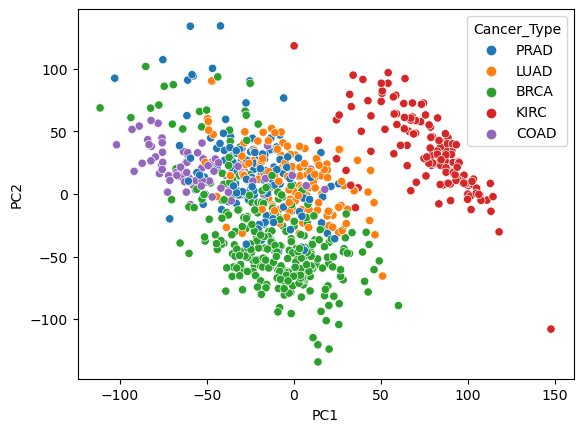

In [26]:
# Create a grid of scatterplots
sns.scatterplot(x='PC1',y='PC2',hue = 'Cancer_Type', data=df_pca_2)
plt.show()

#### 2.2.2. PCA with variance = 0.999

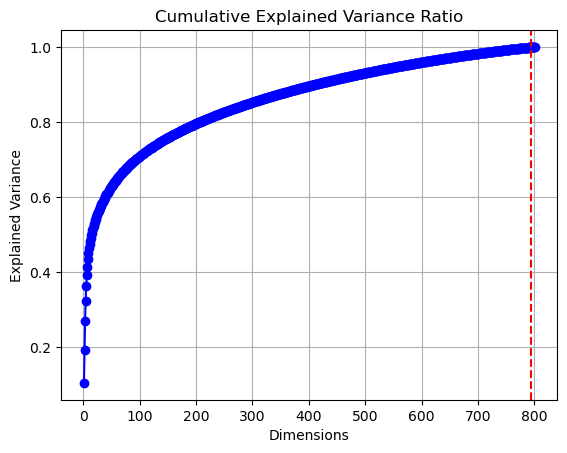

In [27]:
# Plot to see how change the variance of the data according to the dimentionaltity size:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_eda_trans_scal)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Find the number of dimensions that explain at least 95% of the variance
d = np.argmax(cumsum >= 0.999) + 1

# Plot the cumulative sum of explained variance ratio
plt.plot(range(1, len(cumsum) + 1), cumsum, marker='o', linestyle='-', color='b')
plt.axvline(x=d, color='r', linestyle='--')
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

- To keep the variance at 99.9% we need around 800 principal components.
- PCA will allow max number of compounds = number of samples/rows, which is 801.

In [28]:
pca_999 = PCA(n_components=0.999) #or we can just give PCA(n_componenets=0.999)

#Perform fit transform on the scaled data
df_pca_999 = pca_999.fit_transform(df_eda_trans_scal)
df_pca_999.shape

(801, 794)

In [29]:
# Give names to new columns 
df_pca_999 = pd.DataFrame(df_pca_999, columns=['PC' + str(i+1) for i in range(794)])

df_pca_999.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC785,PC786,PC787,PC788,PC789,PC790,PC791,PC792,PC793,PC794
0,-57.736049,94.285550,70.800121,-12.928883,8.008206,36.656460,-3.789330,18.501259,0.676153,2.013929,...,-0.720415,1.503315,-1.484688,0.031331,2.621988,-1.008609,1.463451,-1.789529,0.552203,-0.322845
1,-15.515854,2.009377,-66.766368,1.315401,-24.421490,27.763493,-17.074200,-20.701841,-20.529688,-26.317723,...,-1.196378,0.083914,0.312119,0.301319,0.081733,-1.106835,0.811212,0.352225,-0.152231,-0.127686
2,-71.258060,-19.901825,18.387654,50.163909,24.828240,11.248396,16.962266,-47.547141,-28.247965,-11.596430,...,0.872468,0.391147,-0.289234,0.285386,0.369880,-0.325583,-0.524756,0.112504,0.333015,0.232726
3,-52.012875,-8.265324,59.846067,38.464098,1.518090,22.006024,-5.976637,-22.292365,-13.906397,-12.873680,...,0.247787,0.469546,0.691736,-0.287082,2.825692,-0.570896,-0.691334,1.221548,-0.304873,-1.469641
4,-20.254292,-52.522410,16.024831,-19.655554,24.722107,0.478900,-4.582334,13.588780,-3.662519,28.924009,...,1.660948,-1.230726,-3.987677,0.066572,-0.536810,-0.628624,-0.077637,-0.468184,0.677615,-0.739876


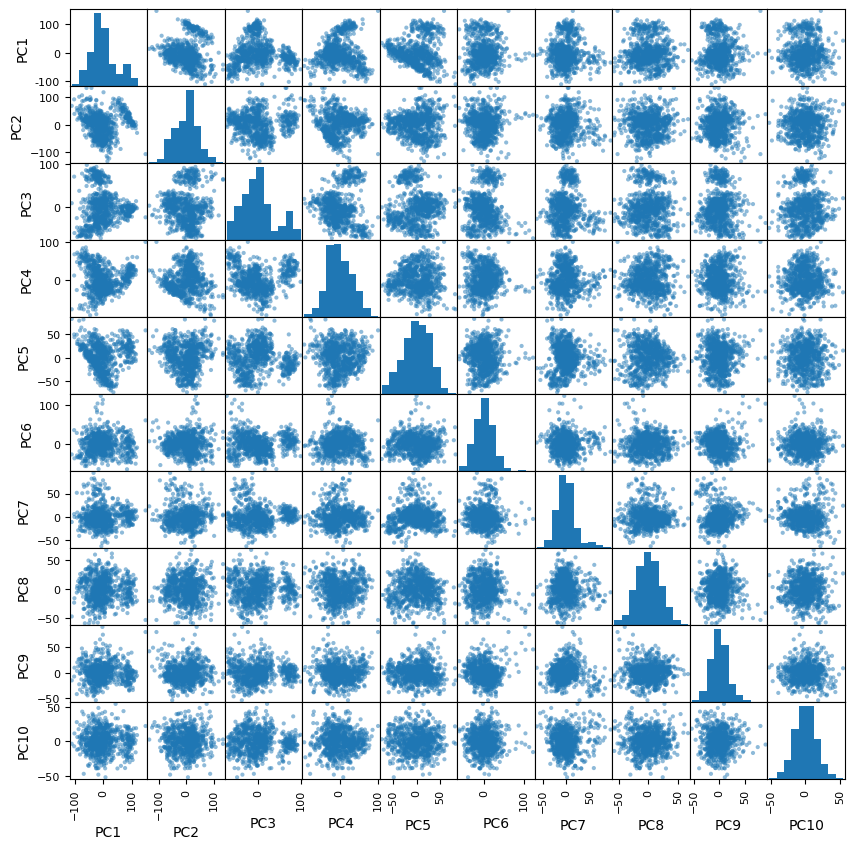

In [30]:
# I want to see a pairplot for first 5 features:

# Select the first 5 features (columns) from your dataset
first_5_features = df_pca_999.iloc[:, :10]

# Create a grid of scatterplots
pd.plotting.scatter_matrix(first_5_features, figsize=(10, 10))
plt.show()

- In this example we can see some clusters.
- lets color them using our class labels.

In [31]:
# Adding labels:
df_pca_999['Cancer_Type']=df_labels['Class']

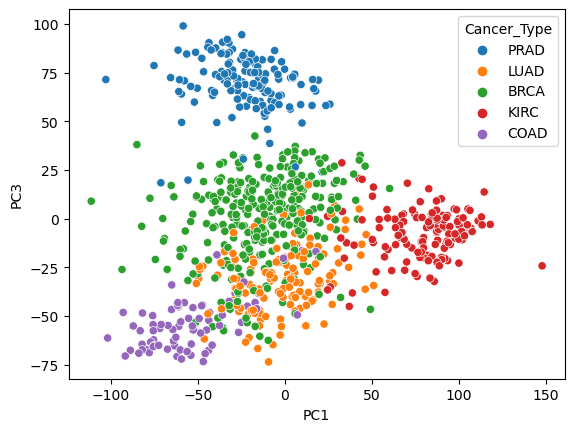

In [32]:
# I want to see a Colorful scatterplot for the example PC3 vs PC5

# Create a grid of scatterplots
sns.scatterplot(x='PC1',y='PC3',hue = 'Cancer_Type', data=df_pca_999)
plt.show()

### 2.3. t-Distributed Stochastic Neighbor Embedding (T-SNE):

- is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional space. It is particularly effective in capturing non-linear relationships and preserving local structures in the data.

In [33]:
#df_eda_trans_scal


#import T-SNE from sklearn
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate=50)
tnse_features = tsne.fit_transform(df_eda_trans_scal)

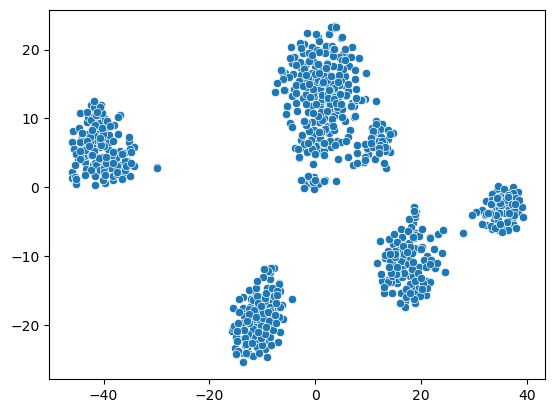

In [34]:
sns.scatterplot(x=tnse_features[:,0], y=tnse_features[:,1] ,data=df_eda_trans_scal)
plt.show()

In [35]:
tsne_data_frame = pd.DataFrame(data=tnse_features, columns=['tsne1','tsne2'])
tsne_data_frame['Cancer_Type'] = df_labels['Class']
tsne_data_frame.head()

,tsne1,tsne2,Cancer_Type
0,-8.750399,-12.214015,PRAD
1,18.777218,-7.402370,LUAD
2,-13.729941,-25.463230,PRAD
3,-13.718712,-17.579996,PRAD
4,-0.850202,14.698808,BRCA


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

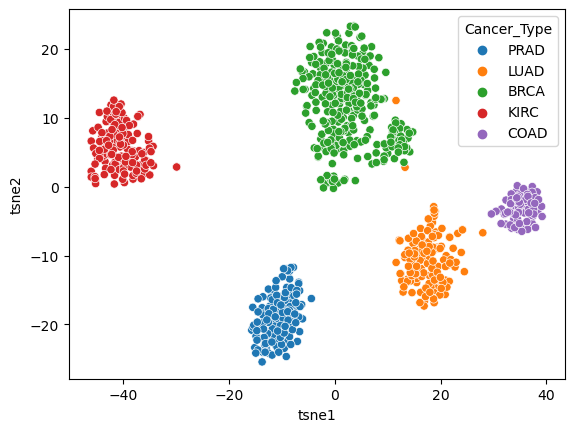

In [36]:
# Present the data on the 5 clusters using seaborn maps 
sns.scatterplot(x='tsne1', y='tsne2',  hue = 'Cancer_Type', data=tsne_data_frame)

### 2.4. LDA:

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
df_lda_2 = lda.fit(df_eda_trans_scal,labels).transform(df_eda_trans_scal)

In [41]:
df_lda_2_frame = pd.DataFrame(data=df_lda_2, columns=['lda1','lda2'])
df_lda_2_frame['Cancer_Type'] = labels

<AxesSubplot:xlabel='lda1', ylabel='lda2'>

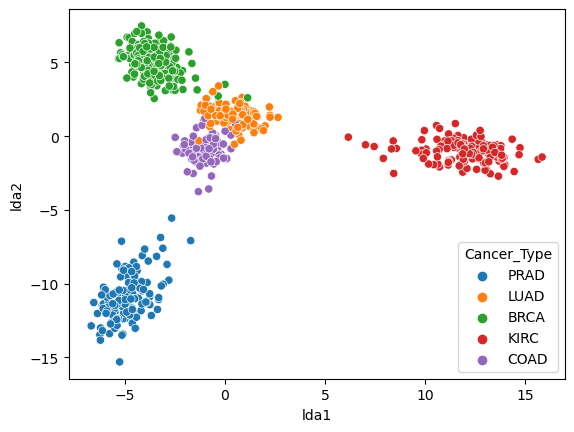

In [42]:
# Present the data on the 5 clusters using seaborn maps 
sns.scatterplot(x='lda1', y='lda2',  hue = 'Cancer_Type', data=df_lda_2_frame)

### 2.5. Conclutions:

- According the tests for different types of dimetionality reduction, I can conclude that method t-SNE gave better results with cancer types separation.

# Step 3: Clustering (K-Mean, hierarchical, DBSCAN)

### 3.1. K-means

- I will test data using dimentionaltity reduction PCA (with n_component=0.999) and t-SNE

#### 3.1.1. K-means full dataset

In [ ]:
df_labels.columns

In [43]:
from sklearn.model_selection import train_test_split

X = df_labels.drop(columns=['Unnamed: 0','Class'])
y = df_labels['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [44]:
# KMEANS Clustering with PCA = 2:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

clusters = KMeans(n_clusters=5, random_state=42)
clusters.fit(X_train)

# Get cluster labels
labels = clusters.labels_

# Calculate scores
silhouette = silhouette_score(X_train, labels)
calinski_harabasz = calinski_harabasz_score(X_train, labels)
davies_bouldin = davies_bouldin_score(X_train, labels)

# Print the scores
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski_harabasz)
print("Davies-Bouldin Score:", davies_bouldin)

Silhouette Score: 0.22697204758273984
Calinski-Harabasz Score: 100.54810942341939
Davies-Bouldin Score: 1.8382681385452844


#### 3.1.2. K-means with PCA (n_component=0.999)

In [45]:
from sklearn.model_selection import train_test_split

X_pca_999 = df_pca_999.drop(columns='Cancer_Type')
y_pca_999 = df_pca_999['Cancer_Type']

X_train_999, X_test_999, y_train_999, y_test_999 = train_test_split(X_pca_999, y_pca_999, test_size=0.20, random_state=42)

In [46]:
# KMEANS Clustering with PCA = 2:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

clusters_pca999 = KMeans(n_clusters=5, random_state=42)
clusters_pca999.fit(X_train_999)

# Get cluster labels
labels = clusters_pca999.labels_

# Calculate scores
silhouette = silhouette_score(X_train_999, labels)
calinski_harabasz = calinski_harabasz_score(X_train_999, labels)
davies_bouldin = davies_bouldin_score(X_train_999, labels)

# Print the scores
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski_harabasz)
print("Davies-Bouldin Score:", davies_bouldin)

Silhouette Score: 0.13094458535858639
Calinski-Harabasz Score: 52.373753348110405
Davies-Bouldin Score: 2.662546268332906


#### 3.1.2. K-means with t-SNE

In [76]:
from sklearn.model_selection import train_test_split

X_tsne = tsne_data_frame.drop(columns='Cancer_Type')
y_tsne = tsne_data_frame['Cancer_Type']

X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y_tsne, test_size=0.20, random_state=42)

In [77]:
# KMEANS Clustering with PCA = 2:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

clusters_tsne = KMeans(n_clusters=5, random_state=42)
clusters_tsne.fit(X_train_tsne)

# Get cluster labels
labels_tsne = clusters_tsne.labels_

# Calculate scores
silhouette = silhouette_score(X_train_tsne, labels_tsne)
calinski_harabasz = calinski_harabasz_score(X_train_tsne, labels_tsne)
davies_bouldin = davies_bouldin_score(X_train_tsne, labels_tsne)

# Print the scores
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski_harabasz)
print("Davies-Bouldin Score:", davies_bouldin)

Silhouette Score: 0.734502
Calinski-Harabasz Score: 3181.1299688258473
Davies-Bouldin Score: 0.34358373842423334


**Conclutions:** 

- The best results were obtained using K-MEAN with t-SNE dimentionality reduction approach. 
- This model has largest Silhouette and Calinski-Harabasz Score, and smallest Davies-Bouldin Score.
- Interesting, that K-MEAN with full dataset does not produce good results. 

### 3.2. Hierarchical method

- According the previous results, clustering model workes best with t-SNE approach.
- Here, I will test another cluster model AgglomerativeClustering with t-SNE.

In [78]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

clusters_hier = AgglomerativeClustering(n_clusters=5)
labels = clusters_hier.fit_predict(X_train_tsne)

# Calculate scores
silhouette = silhouette_score(X_train_tsne, labels)
calinski_harabasz = calinski_harabasz_score(X_train_tsne, labels)
davies_bouldin = davies_bouldin_score(X_train_tsne, labels)

# Print the scores
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski_harabasz)
print("Davies-Bouldin Score:", davies_bouldin)


Silhouette Score: 0.73400784
Calinski-Harabasz Score: 3171.7580102772486
Davies-Bouldin Score: 0.34401464087126354


### 3.3. Mean Shift Method

In [50]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

clusters_msh = MeanShift()
labels = clusters_msh.fit_predict(X_tsne)

# Calculate scores
silhouette = silhouette_score(X_tsne, labels)
calinski_harabasz = calinski_harabasz_score(X_tsne, labels)
davies_bouldin = davies_bouldin_score(X_tsne, labels)

# Print the scores
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski_harabasz)
print("Davies-Bouldin Score:", davies_bouldin)

Silhouette Score: 0.5610193
Calinski-Harabasz Score: 189.47953068838206
Davies-Bouldin Score: 0.5285393598613392


### 3.4. Comparison obtained clusters with actual Cancer Type groups of genes:

- Here I will test results of my best model K-Mean with t-SNE.

- To evaluate the accuracy of my cluster model compared to the actual Cancer Type groups, you can use external clustering evaluation metrics such as Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI). 

- These metrics compare the cluster assignments with the true labels and provide a measure of similarity or agreement between them.

In [51]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate ARI
ari = adjusted_rand_score(y_tsne, labels_tsne)

# Calculate NMI
nmi = normalized_mutual_info_score(y_tsne, labels_tsne)

# Print the scores
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


- An ARI of 1.0 means that the clusters obtained by your model and the true labels are in complete agreement, with no disagreements or errors. Similarly, an NMI of 1.0 indicates a perfect information gain between the clusters and the true labels.

In [52]:
import numpy as np

unique_labels, label_counts = np.unique(labels_tsne, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 61
Label: 1, Count: 29
Label: 2, Count: 17
Label: 3, Count: 25
Label: 4, Count: 29


In [ ]:
#df_labels['Class'].value_counts()

### 3.5. Conclusions:

- I am getting very close results for both K-means and AgglomerativeClustering, it suggests that the clusters produced by the two algorithms are similar in terms of their internal cohesion, separation, and overall quality. 
- This also could mean that the data is well-suited for clustering and that the clusters formed by both algorithms exhibit similar characteristics.
- In summary, an ARI and NMI of 1.0 imply that your cluster model has accurately captured the underlying patterns and structure in the data, accurately grouping samples into their respective Cancer Type categories.

# Step 4: Classifiaction Models:

- multiclass SVM 
- Random Forest 
- Deep Neural Network

### 4.1. multiclass SVM and Random Forest

In [96]:
# Label Encoding:
from sklearn.preprocessing import LabelEncoder

# Create label encoder object
label_encoder = LabelEncoder()

# Fit label encoder on y_train
label_encoder.fit(y_train)

# Apply label encoding to y_train and y_test
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [54]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import time
import pandas as pd

# Define algorithms to try
algorithms = []
algorithms.append(('SVM', SVC()))
algorithms.append(('Random Forest', RandomForestClassifier()))

# Initialize lists
names = []
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []
cross_validation_scores = []
runtime = []

# Iterate over each element in algorithms
for name, clf in algorithms:
    t1 = time.time()
    names.append(name)
    clf.fit(X_train, y_train_encoded)
    train_rmse.append(sqrt(mean_squared_error(y_train_encoded, clf.predict(X_train))))
    test_rmse.append(sqrt(mean_squared_error(y_test_encoded, clf.predict(X_test))))
    train_r2.append(r2_score(y_train_encoded, clf.predict(X_train)))
    test_r2.append(r2_score(y_test_encoded, clf.predict(X_test)))
    cross_validation_scores.append(cross_val_score(clf, X, y, cv=5).mean())
    t2 = time.time()
    runtime.append(t2 - t1)

# Create comparison dataframe
model_comparison = pd.DataFrame({'Algorithm': names,
                                 'Train RMSE': train_rmse,
                                 'Test RMSE': test_rmse,
                                 'Train r2 score': train_r2,
                                 'Test r2 score': test_r2,
                                 'Cross validation score': cross_validation_scores,
                                 'Runtime': runtime})

# Sort by Test RMSE
model_comparison.sort_values(by=['Test RMSE'], inplace=True)

In [55]:
model_comparison

,Algorithm,Train RMSE,Test RMSE,Train r2 score,Test r2 score,Cross validation score,Runtime
0,SVM,0.118585,0.0,0.993944,1.0,0.996258,118.543685
1,Random Forest,0.000000,0.0,1.000000,1.0,0.997508,9.749146


- Based on these results, both SVM and Random Forest algorithms show excellent performance and are capable of accurately predicting the target variable. 
- However, Random Forest in 2 times faster than SVM.

### 4.2. Deep Neural Network:

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

#### 4.2.1. Full data set:

In [62]:
print(X_train.shape)
print(X_test.shape)

(640, 20531)
(161, 20531)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

model_3 = Sequential([
    Dense(36, activation='relu', input_shape=(20531,)),
    BatchNormalization(),
    Dense(18, activation='relu'),
    BatchNormalization(),
    Dropout(0.55),
    Dense(5, activation='softmax'),
])

model_3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

BATCH_SIZE = 200

# Convert y_train to one-hot encoded format
y_train_encoded = to_categorical(y_train_encoded, num_classes=5)

history = model_3.fit(
    X_train,
    y_train_encoded,
    batch_size=BATCH_SIZE,
    epochs=200,
    validation_split=0.20,
    shuffle=True,
    verbose=1
)


Epoch 1/200
3/3 [==============================] - 1s 109ms/step - loss: 1.9132 - accuracy: 0.3145 - val_loss: 39.6648 - val_accuracy: 0.1562
Epoch 2/200
3/3 [==============================] - 0s 30ms/step - loss: 0.9015 - accuracy: 0.6270 - val_loss: 50.7017 - val_accuracy: 0.1562
Epoch 3/200
3/3 [==============================] - 0s 31ms/step - loss: 0.7548 - accuracy: 0.7090 - val_loss: 38.9149 - val_accuracy: 0.1562
Epoch 4/200
3/3 [==============================] - 0s 31ms/step - loss: 0.6516 - accuracy: 0.7793 - val_loss: 30.9754 - val_accuracy: 0.1562
Epoch 5/200
3/3 [==============================] - 0s 31ms/step - loss: 0.6190 - accuracy: 0.7715 - val_loss: 26.1813 - val_accuracy: 0.1562
Epoch 6/200
3/3 [==============================] - 0s 32ms/step - loss: 0.5201 - accuracy: 0.8242 - val_loss: 22.8447 - val_accuracy: 0.1562
Epoch 7/200
3/3 [==============================] - 0s 32ms/step - loss: 0.5672 - accuracy: 0.8066 - val_loss: 20.2466 - val_accuracy: 0.1562
Epoch 8/200


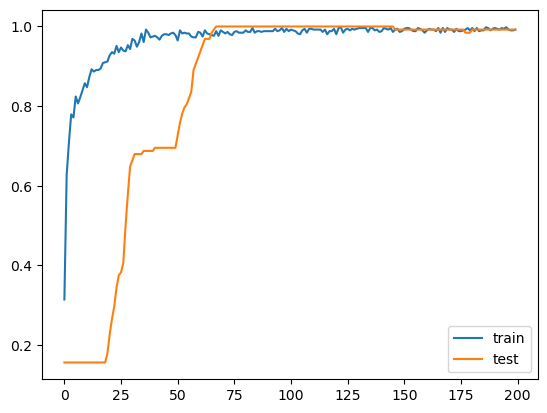

In [74]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#### 4.2.2. with t-SNE dimentionality reduction

In [89]:
from sklearn.model_selection import train_test_split

X_tsne = tsne_data_frame.drop(columns='Cancer_Type')
y_tsne = tsne_data_frame['Cancer_Type']

X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y_tsne, test_size=0.20, random_state=42)

In [90]:
# Label Encoding:
from sklearn.preprocessing import LabelEncoder

# Create label encoder object
label_encoder = LabelEncoder()

# Fit label encoder on y_train
label_encoder.fit(y_train_tsne)

# Apply label encoding to y_train and y_test
y_train_tsne_encoded = label_encoder.transform(y_train_tsne)
y_test_tsne_encoded = label_encoder.transform(y_test_tsne)

In [81]:
print(X_train_tsne.shape)
print(X_test_tsne.shape)

(640, 2)
(161, 2)


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

model_tsne = Sequential([
    Dense(36, activation='relu', input_shape=(2,)),
    BatchNormalization(),
    Dense(18, activation='relu'),
    BatchNormalization(),
    Dropout(0.55),
    Dense(5, activation='softmax'),
])

model_tsne.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

BATCH_SIZE = 200

# Convert y_train to one-hot encoded format
y_train_tsne_encoded = to_categorical(y_train_tsne_encoded, num_classes=5)

history = model_tsne.fit(
    X_train_tsne,
    y_train_tsne_encoded,
    batch_size=BATCH_SIZE,
    epochs=200,
    validation_split=0.20,
    shuffle=True,
    verbose=1
)

Epoch 1/200
3/3 [==============================] - 1s 61ms/step - loss: 2.0231 - accuracy: 0.2422 - val_loss: 3.5473 - val_accuracy: 0.2500
Epoch 2/200
3/3 [==============================] - 0s 13ms/step - loss: 1.7715 - accuracy: 0.3535 - val_loss: 3.0873 - val_accuracy: 0.2656
Epoch 3/200
3/3 [==============================] - 0s 14ms/step - loss: 1.4846 - accuracy: 0.3848 - val_loss: 2.7135 - val_accuracy: 0.2812
Epoch 4/200
3/3 [==============================] - 0s 12ms/step - loss: 1.2446 - accuracy: 0.4785 - val_loss: 2.4202 - val_accuracy: 0.3281
Epoch 5/200
3/3 [==============================] - 0s 14ms/step - loss: 1.0439 - accuracy: 0.5586 - val_loss: 2.1868 - val_accuracy: 0.4219
Epoch 6/200
3/3 [==============================] - 0s 13ms/step - loss: 0.9799 - accuracy: 0.5684 - val_loss: 1.9977 - val_accuracy: 0.4766
Epoch 7/200
3/3 [==============================] - 0s 13ms/step - loss: 0.9027 - accuracy: 0.6426 - val_loss: 1.8311 - val_accuracy: 0.5391
Epoch 8/200
3/3 [===

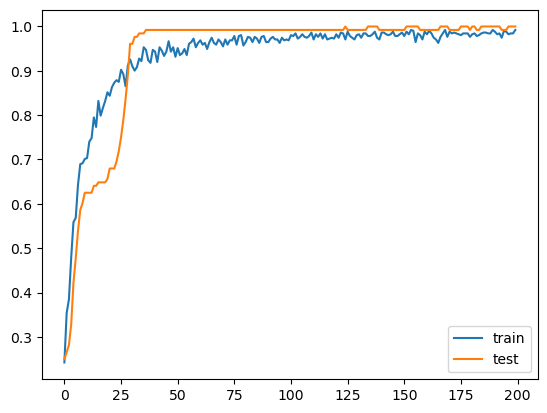

In [92]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#### 4.2.3. Plot confusion matrix:

6/6 [==============================] - 0s 812us/step


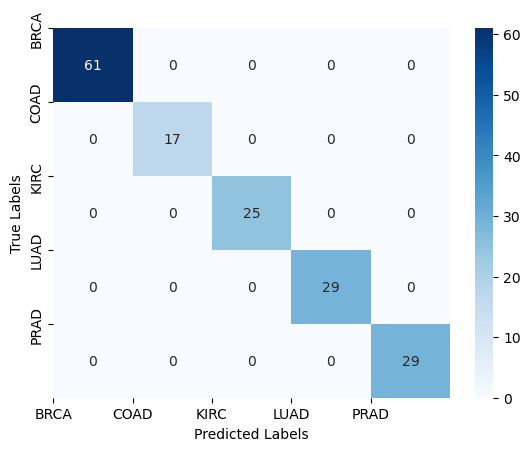

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert y_test_tsne_encoded to one-hot encoded format
y_test_tsne_encoded_onehot = to_categorical(y_test_tsne_encoded, num_classes=5)

# Predict labels for the test set
y_pred = model_tsne.predict(X_test_tsne)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert predicted labels back to categorical
y_pred_labels_onehot = to_categorical(y_pred_labels, num_classes=5)

# Compute confusion matrix
cm = confusion_matrix(y_test_tsne_encoded, y_pred_labels)

# Define class labels
class_labels = label_encoder.classes_

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.show()

### 4.3. Feature selection algorithms (forward selection)

- Here, I will consider the case of data after the dimentionality reduction with 20 components.

In [106]:
# Import PCA from sklearn and define the n_components as 2 
from sklearn.decomposition import PCA

pca_20=PCA(n_components=20)

#Perform fit transform on the scaled data
df_pca_20 = pca_20.fit_transform(df_eda_trans_scal)
df_pca_20.shape

(801, 20)

In [107]:
# Give names to new columns 
df_pca_20 = pd.DataFrame(df_pca_20, columns=['PC' + str(i+1) for i in range(20)])

df_pca_20.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-57.736049,94.285550,70.800121,-12.928883,8.008206,36.656460,-3.789341,18.501257,0.676104,2.013932,3.699671,6.023514,8.503057,-13.095624,4.004737,-6.920488,6.925207,-1.998973,2.279437,5.491876
1,-15.515854,2.009377,-66.766368,1.315401,-24.421490,27.763493,-17.074213,-20.701859,-20.529637,-26.317270,-8.063817,-0.841287,0.362305,27.431001,-12.565196,0.571182,8.523926,-4.457420,4.271459,14.028114
2,-71.258060,-19.901825,18.387654,50.163909,24.828240,11.248396,16.962255,-47.547145,-28.247962,-11.596334,-14.250051,-9.531363,-31.354648,18.009823,-2.906047,3.369223,7.795385,22.240192,8.598659,-0.400597
3,-52.012875,-8.265324,59.846067,38.464098,1.518090,22.006025,-5.976641,-22.292375,-13.906372,-12.873718,5.337036,-22.693960,-10.151446,-8.344360,-4.435993,-11.349750,-3.846976,14.794520,-10.699946,13.358380
4,-20.254292,-52.522410,16.024831,-19.655554,24.722107,0.478901,-4.582336,13.588765,-3.662521,28.924177,7.292927,-5.204550,9.456507,12.978706,1.293426,-19.161574,-4.028240,1.569085,2.923354,-6.040231


In [108]:
# Adding labels:
df_pca_20['Cancer_Type']=df_labels['Class']

In [110]:
from sklearn.model_selection import train_test_split

X_pca_20 = df_pca_20.drop(columns='Cancer_Type')
y_pca_20 = df_pca_20['Cancer_Type']

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_pca_20, y_pca_20, test_size=0.20, random_state=42)

In [111]:
# Label Encoding:
from sklearn.preprocessing import LabelEncoder

# Create label encoder object
label_encoder = LabelEncoder()

# Fit label encoder on y_train
label_encoder.fit(y_train_20)

# Apply label encoding to y_train and y_test
y_train_20_encoded = label_encoder.transform(y_train_20)
y_test_20_encoded = label_encoder.transform(y_test_20)

In [112]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import time
import pandas as pd

# Define algorithms to try
algorithms = []
algorithms.append(('SVM', SVC()))
algorithms.append(('Random Forest', RandomForestClassifier()))

# Initialize lists
names = []
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []
cross_validation_scores = []
runtime = []

# Iterate over each element in algorithms
for name, clf in algorithms:
    t1 = time.time()
    names.append(name)
    clf.fit(X_train_20, y_train_20_encoded)
    train_rmse.append(sqrt(mean_squared_error(y_train_20_encoded, clf.predict(X_train_20))))
    test_rmse.append(sqrt(mean_squared_error(y_test_20_encoded, clf.predict(X_test_20))))
    train_r2.append(r2_score(y_train_20_encoded, clf.predict(X_train_20)))
    test_r2.append(r2_score(y_test_20_encoded, clf.predict(X_test_20)))
    cross_validation_scores.append(cross_val_score(clf, X_pca_20, y_pca_20, cv=5).mean())
    t2 = time.time()
    runtime.append(t2 - t1)

# Create comparison dataframe
model_comparison = pd.DataFrame({'Algorithm': names,
                                 'Train RMSE': train_rmse,
                                 'Test RMSE': test_rmse,
                                 'Train r2 score': train_r2,
                                 'Test r2 score': test_r2,
                                 'Cross validation score': cross_validation_scores,
                                 'Runtime': runtime})

# Sort by Test RMSE
model_comparison.sort_values(by=['Test RMSE'], inplace=True)

In [113]:
model_comparison

,Algorithm,Train RMSE,Test RMSE,Train r2 score,Test r2 score,Cross validation score,Runtime
0,SVM,0.0,0.000000,1.0,1.000000,0.995008,0.092546
1,Random Forest,0.0,0.352454,1.0,0.948613,0.983773,0.854270


#### 4.3.1. Forward feature selection

In [114]:
# Forward feature selection:

from mlxtend.feature_selection import SequentialFeatureSelector

# Create a classifier (e.g., Random Forest)
classifier = RandomForestClassifier()

# Forward Selection
selector_forward = SequentialFeatureSelector(classifier,
                                             k_features='best',
                                             forward=True,
                                             floating=False,
                                             scoring='accuracy',
                                             cv=5)

# Fit the selector on the training data
selector_forward.fit(X_train_20, y_train_20_encoded)

# Get the selected feature indices
selected_features_forward = selector_forward.k_feature_idx_

In [123]:
# Significant Principal Components:
selected_features_forward

(0, 1, 2, 3, 4, 6, 7, 10)

#### 4.3.2. Validation of the selected principal components using statistical significance testing (F-test): 

In [125]:
from sklearn.feature_selection import f_classif

# Separate the features (X) and target (y) variables
X = df_pca_20.drop('Cancer_Type', axis=1)
y = df_pca_20['Cancer_Type']

# Perform F-test for feature significance
f_values, p_values = f_classif(X, y)

# Create a DataFrame of features and their corresponding F-values and p-values
result_df = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'P-value': p_values})

# Filter features with p-value <= 0.05
significant_features = result_df[result_df['P-value'] <= 0.05]['Feature'].tolist()
no_significant_features = result_df[result_df['P-value'] > 0.05]['Feature'].tolist()

print("Significant Features:")
print((significant_features))

print("Non-Significant Features:")
print((no_significant_features))

Significant Features:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12']
Non-Significant Features:
['PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']
